In [1]:
import matplotlib.pyplot as plt
import scipy.optimize
import pandas as pd
import numpy as np
import scipy 
G     = 6.67 * 10**(-8.)  # cm^3 g^-1 s^-2
sigma = 5.67 * 10**(-5.)  # erg cm^-2 K^-4 s^-1
M_sun = 1.99 * 10**33.    # g
R_sun = 6.96 * 10**10.    # cm
M_earth   = 5.976 * 10**27. # g
R_earth   = 6.378 * 10**8.  # cm
F_inc_earth = 1.36 * 10**6. # erg cm^-2 sec^-1 
sun2earth = 333000        # earth masses
pc2cm = 3.086 * 10**18.   # cm in a parsec
d2s   = 86400             # seconds in a day
pi    = np.pi

# ASTR 597, W17: Final Exam

$\textbf{Problem 1: }$

$\textbf{Part a:}$

In [2]:
# Part a: Estimate alpha and f(alpha)
a_venus = 0.723    # AU, semi-major axis of Venus
a_earth = 1        # AU, semi-major axis of Earth

alpha   = a_venus/a_earth
f_alpha = 10**(-0.06 - (2.44*alpha) + (5.22*(alpha**2.)))

print(alpha,f_alpha)

0.723 8.02648465965101


For Venus and Earth, $\alpha$ = 0.723 and f($\alpha$) ~ 8.026.

$\textbf{Part b:}$

The synodic frequency refers to to the frequency of alignments (or conjunctions) between the inner and outer (or secondary) bodies. This frequency comes about due to the periodicity of the inner planet's orbit fluctuation (or variation) depending on the outer planet's affecting gravitational force. This dependency is what allows us to use the TTV method to determine information about this system. 

Physically, the distribution of the planetary system is the cause of this dependency as the outer/secondary planet pulls or pushes the inner planet depending on their position in their orbits. These push/pulls change the speed of the inner planet's orbit, causing variations in the transit times of the planet. So, these variations give rise to the aforementioned synodic frequency which spans the frequency between the conjunctions of these two bodies or the "restarting" point of the periodic cycle of transit variations.

$\textbf{Part c:}$

In [3]:
# Assume constants and get dt_chop from plot
P_venus        = 243 #days
P_earth        = 365 #days
dt_chop        = 1 #min, from plot
dt_chop        = dt_chop/60/24 #days

def get_m_2(P_1,dt_chop,f_alpha):
    global pi
    m_2 = dt_chop*(2*pi/(P_1*f_alpha))
    return m_2    # solar masses

m_earth = get_m_2(P_venus,dt_chop,f_alpha)
print(m_earth*sun2earth)

0.7449548572293988


The calculated Earth mass is ~0.74 M$_{\oplus}$.

$\textbf{Part d:}$

TTV's scale with the transiting period of the inner planet as this the the physical measurement that is being made. In other words, the inner planet's orbit is being lengthened and shortened by the gravitational pull of the outer/secondary planet. This physical change occuring to the orbit is the variable that TTV's are measuring. Since this change to the inner planet's orbit is caused by the gravitational force of secondary planet, the TTV scales with the secondary planet's mass since this value dictates the scale of that force.

$\textbf{Part e:}$

The pitfalls of the TTV Method:
- Requires a lot of time to monitor the planets and observe multiple transits
- Needs good timing precision to determine variations in transit times
- There are a number of degeneracies that arise:
     - period 
     - eccentricity-eccentricity
     - mass-eccentricity 
     
*** Some of these degeneracies can be broken by examining multiple planet transits and other degeneracy frequencies

$\textbf{Problem 2}$

In [4]:
df = pd.read_csv('nature21360-f1_folded.csv',names=['Planet','TimefromMidTransit','Flux','Error','TransitModel'],skiprows=1)

In [5]:
df_b = df[df.Planet == 'b']
df_c = df[df.Planet == 'c']
df_d = df[df.Planet == 'd']
df_e = df[df.Planet == 'e']
df_f = df[df.Planet == 'f']
df_g = df[df.Planet == 'g']
df_h = df[df.Planet == 'h']

b_P,c_P,d_P,e_P,f_P,g_P = 1.51087081,2.4218233,4.049610,6.099615,9.206690,12.35294
colors  = ['IndianRed','Salmon','Orange','Green','SkyBlue','SteelBlue','Purple']
planets = ['b','c','d','e','f','g','h']
offset = 0.01

astar_F_bol = 1.12 * 10**-10.  # erg cm^-2 s^-1
astar_dist  = 12.2 * pc2cm     # cm
astar_T_eff = 2560             # K

In [6]:
def get_radius_ratio(transit_depth):
    # k^2 = (R_p/R_star)^2
    k = (transit_depth)**0.5
    return k

def get_impact_param(radius_ratio,transit_time,ingress):
    if (1-(radius_ratio*transit_time/ingress)) < 0:
        #print('negative impact param!')
        b = 0
    else:
        b = (1-(radius_ratio*transit_time/ingress))**0.5
    return b

def get_density(period,transit_time,impact_param):
    global G,pi
    rho = (3./(pi**2.))*((period*d2s)/(G*(transit_time*d2s)**3.))*(1-(impact_param**2))**(3./2)
    return rho

def get_stellar_radius(F_bol,T_eff,distance):
    global sigma
    R_s = ((F_bol/(sigma * (T_eff**4.))) * distance**2.)**0.5
    return R_s

def get_RV_amp(period,planet_mass,stellar_mass):
    global G,pi
    A = (2*pi*G/(period*d2s))**(1./3.) * ((planet_mass*M_earth)/
                                    ((astar_mass) + (planet_mass*M_earth))**(2./3.))
    return A

def get_F_incident(planet_radius_ratio):
    global pi,astar_F_bol
    F_inc = astar_F_bol * pi * (planet_radius_ratio*astar_radius)**2.
    return F_inc # ergs/s

def get_mass_watery(x):
    global k_1,k_2,k_3,radius
    M_1,R_1 = 6.41,3.63
    y = [k_1 + (np.log10(x[0]/M_1)/3) - k_2*(x[0]/M_1)**k_3 - np.log10(radius/R_1)]
    return y

def get_mass_rocky(x):
    global k_1,k_2,k_3,radius
    M_1,R_1 = 7.38,3.58
    y = [k_1 + (np.log10(x[0]/M_1)/3) - k_2*(x[0]/M_1)**k_3 - np.log10(radius/R_1)]
    return y

def get_mass_earthy(x):
    global k_1,k_2,k_3,radius
    M_1,R_1 = 6.41,3.19
    y = [k_1 + (np.log10(x[0]/M_1)/3) - k_2*(x[0]/M_1)**k_3 - np.log10(radius/R_1)]
    return y

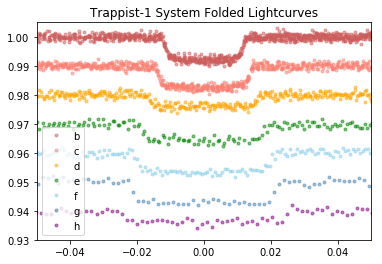

In [7]:
plt.plot(df_b.TimefromMidTransit,df_b.Flux,'.',color=colors[0],alpha=0.5,label=planets[0])
plt.plot(df_c.TimefromMidTransit,df_c.Flux-offset,'.',
         color=colors[1],alpha=0.5,label=planets[1])
plt.plot(df_d.TimefromMidTransit,df_d.Flux-offset*2,'.',
         color=colors[2],alpha=0.5,label=planets[2])
plt.plot(df_e.TimefromMidTransit,df_e.Flux-offset*3,'.',
         color=colors[3],alpha=0.5,label=planets[3])
plt.plot(df_f.TimefromMidTransit,df_f.Flux-offset*4,'.',
         color=colors[4],alpha=0.5,label=planets[4])
plt.plot(df_g.TimefromMidTransit,df_g.Flux-offset*5,'.',
         color=colors[5],alpha=0.5,label=planets[5])
plt.plot(df_h.TimefromMidTransit,df_h.Flux-offset*6,'.',
         color=colors[6],alpha=0.5,label=planets[6])
plt.ylim(0.93,1.005)
plt.xlim(-0.05,0.05)
plt.legend()
plt.title('Trappist-1 System Folded Lightcurves')
plt.show()

$\textbf{Part a & c:}$

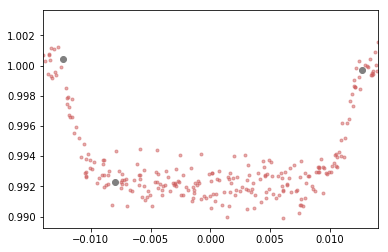

The radius ratio for planet b is:     0.0901
The impact parameter for planet b is: 0.6923
The density for planet b is:          22.1529 g cm^-3


In [8]:
# Planet b: get radius ratio, impact parameters, and density
i   = 0
plt.plot(df_b.TimefromMidTransit,df_b.Flux,'.',color=colors[i],alpha=0.5)
plt.xlim(-0.014,0.014)
plt.plot(-0.012344,1.000440,'o',color='Grey')
plt.plot(-0.008015,0.992317,'o',color='Grey')
plt.plot(0.012666,0.999710,'o',color='Grey')
plt.show()
#print(df_b[(df_b.TimefromMidTransit < 0.015) & (df_b.TimefromMidTransit > -0.014)])

# Index values for ingress/transit depth: 517, 555; and transit duration: 754
b_transit_d = 1.000440 - 0.992317      # flux
b_ingress   = -0.008015 - (-0.012344)  # days
b_transit_t = 0.012666 - (-0.012344)   # days

b_k = get_radius_ratio(b_transit_d)
b_b = get_impact_param(b_k,b_transit_t,b_ingress)
b_rho = get_density(b_P,b_transit_t,b_b)

print('The radius ratio for planet '+ planets[i] + ' is:     '+ str(round(b_k,4)))
print('The impact parameter for planet '+ planets[i] + ' is: '+ str(round(b_b,4)))
print('The density for planet '+ planets[i] + ' is:          '+ str(round(b_rho,4)),r'g cm^-3')

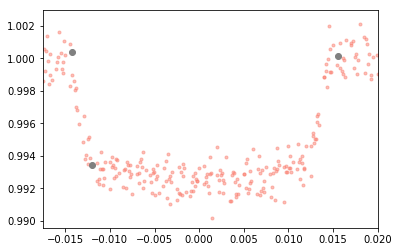

The radius ratio for planet c is:     0.0833
The impact parameter for planet c is: 0
The density for planet c is:          56.2407 g cm^-3


In [9]:
# Planet c: get radius ratio, impact parameters, and density
i = 1
plt.plot(df_c.TimefromMidTransit,df_c.Flux,'.',alpha=0.5,color=colors[i])
plt.xlim(-0.0175,0.02)
plt.plot(-0.014212,1.000369,'o',color='Grey')
plt.plot(-0.011994,0.993428,'o',color='Grey')
plt.plot(0.015522,1.000137,'o',color='Grey')
plt.show()
#print(df_c[(df_c.TimefromMidTransit < 0.02) & (df_c.TimefromMidTransit > 0.01)])

# Index values for ingress/transit depth: 2093, 2109 ; and transit duration: 2309
c_transit_d = 1.000369 - 0.993428     # flux
c_ingress   = -0.011994 - (-0.014212) # days
c_transit_t = 0.015522 - (-0.014212)  # days


#print(c_transit_d,c_ingress,c_transit_t)
c_k = get_radius_ratio(c_transit_d)
c_b = get_impact_param(c_k,c_transit_t,c_ingress)
c_rho = get_density(c_P,c_transit_t,c_b)

print('The radius ratio for planet '+ planets[i] + ' is:     '+ str(round(c_k,4)))
print('The impact parameter for planet '+ planets[i] + ' is: '+ str(round(c_b,4)))
print('The density for planet '+ planets[i] + ' is:          '+ str(round(c_rho,4)),r'g cm^-3')

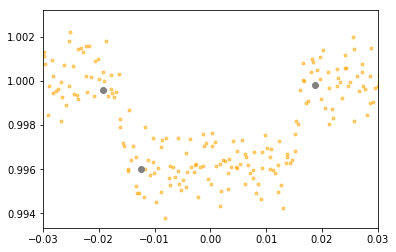

The radius ratio for planet d is:      0.0596
The impact parameter for planet d is:  0.8561
The density for planet d is:           11.3284 g cm^-3


In [10]:
# Planet d: get radius ratio, impact parameters, and density
i = 2
plt.plot(df_d.TimefromMidTransit,df_d.Flux,'.',alpha=0.5,color=colors[i])
plt.xlim(-0.03,0.03)
plt.plot(-0.019327,0.999593,'o',color='Grey')
plt.plot(-0.012378,0.996035,'o',color='Grey')
plt.plot(0.018736,0.999815,'o',color='Grey')
plt.show()
#print(df_d[(df_d.TimefromMidTransit > -0.0) & (df_d.TimefromMidTransit < 0.025)])

# Index values for ingress/transit depth: 3223, 3247 ; and transit duration: 3351
d_transit_d = 0.999593 - 0.996035      # flux
d_ingress   = -0.012378 - (-0.019327)  # days
d_transit_t = 0.018736 - (-0.012378)   # days

d_k = get_radius_ratio(d_transit_d)
d_b = get_impact_param(d_k,d_transit_t,d_ingress)
d_rho = get_density(d_P,d_transit_t,d_b)

print('The radius ratio for planet '+ planets[i] + ' is:      '+ str(round(d_k,4)))
print('The impact parameter for planet '+ planets[i] + ' is:  '+ str(round(d_b,4)))
print('The density for planet '+ planets[i] + ' is:          ', round(d_rho,4),r'g cm^-3')

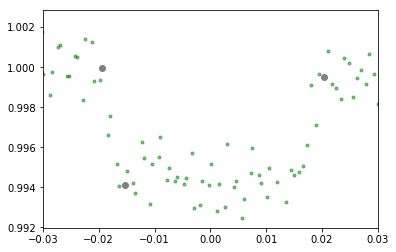

The radius ratio for planet e is:      0.0764
The impact parameter for planet e is:  0.5166
The density for planet e is:           37.0754 g cm^-3


In [11]:
# Planet e: get radius ratio, impact parameters, and density
i = 3
plt.plot(df_e.TimefromMidTransit,df_e.Flux,'.',alpha=0.5,color=colors[i])
plt.xlim(-0.03,0.03)
plt.plot(-0.019424,0.999964,'o',color='Grey')
plt.plot(-0.015276,0.994126,'o',color='Grey')
plt.plot(0.020376,0.999496,'o',color='Grey')
plt.show()
#print(df_e[(df_e.TimefromMidTransit > 0.01) & (df_e.TimefromMidTransit < 0.03)])

# Index values for ingress/transit depth: 3862, 3867 ; and transit duration: 3913
e_transit_d = 0.999964 - 0.994126      # flux
e_ingress   = -0.015276 - (-0.019424)  # days
e_transit_t = 0.020376 - (-0.019424)   # days

e_k = get_radius_ratio(e_transit_d)
e_b = get_impact_param(e_k,e_transit_t,e_ingress)
e_rho = get_density(e_P,e_transit_t,e_b)

print('The radius ratio for planet '+ planets[i] + ' is:      '+ str(round(e_k,4)))
print('The impact parameter for planet '+ planets[i] + ' is:  '+ str(round(e_b,4)))
print('The density for planet '+ planets[i] + ' is:          ', round(e_rho,4),r'g cm^-3')

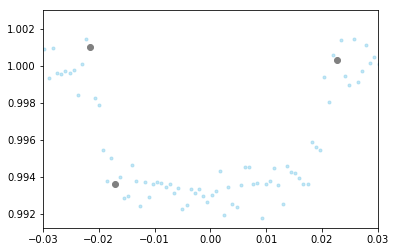

The radius ratio for planet f is:      0.0862
The impact parameter for planet f is:  0.3917
The density for planet f is:           50.689 g cm^-3


In [12]:
# Planet f: get radius ratio, impact parameters, and density
i = 4
plt.plot(df_f.TimefromMidTransit,df_f.Flux,'.',alpha=0.5,color=colors[i])
plt.xlim(-0.03,0.03)
plt.plot(-0.021508,1.001026,'o',color='Grey')
plt.plot(-0.017009,0.993602,'o',color='Grey')
plt.plot(0.022694,1.000324,'o',color='Grey')
plt.show()
#print(df_f[(df_f.TimefromMidTransit < 0.03) & (df_f.TimefromMidTransit > 0.01)])

# Index values for ingress/transit depth: 4271, 4277 ; and transit duration: 4327
f_transit_d = 1.001026 - 0.993602      # flux
f_ingress   = -0.017009 - (-0.021508)  # days
f_transit_t = 0.022694 - (-0.021508)   # days

f_k = get_radius_ratio(f_transit_d)
f_b = get_impact_param(f_k,f_transit_t,f_ingress)
f_rho = get_density(f_P,f_transit_t,f_b)

print('The radius ratio for planet '+ planets[i] + ' is:      '+ str(round(f_k,4)))
print('The impact parameter for planet '+ planets[i] + ' is:  '+ str(round(f_b,4)))
print('The density for planet '+ planets[i] + ' is:          ', round(f_rho,4),r'g cm^-3')

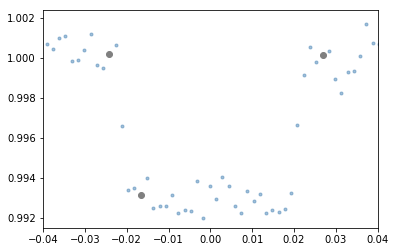

The radius ratio for planet g is:      0.0841
The impact parameter for planet g is:  0.6543
The density for planet g is:           24.6917 g cm^-3


In [13]:
# Planet g: get radius ratio, impact parameters, and density
i = 5
plt.plot(df_g.TimefromMidTransit,df_g.Flux,'.',alpha=0.5,color=colors[i])
plt.xlim(-0.04,0.04)
plt.plot(-0.024121,1.000194,'o',color='Grey')
plt.plot(-0.016632,0.993122,'o',color='Grey')
plt.plot(0.026805,1.000164,'o',color='Grey')
plt.show()
#print(df_g[(df_g.TimefromMidTransit < 0.03) & (df_g.TimefromMidTransit > 0.01)])

# Index values for ingress/transit depth: 4271, 4277 ; and transit duration: 4327
g_transit_d = 1.000194 - 0.993122      # flux
g_ingress   = -0.016632 - (-0.024121)  # days
g_transit_t = 0.026805 - (-0.024121)   # days

g_k = get_radius_ratio(g_transit_d)
g_b = get_impact_param(g_k,g_transit_t,g_ingress)
g_rho = get_density(g_P,g_transit_t,g_b)

print('The radius ratio for planet '+ planets[i] + ' is:      '+ str(round(g_k,4)))
print('The impact parameter for planet '+ planets[i] + ' is:  '+ str(round(g_b,4)))
print('The density for planet '+ planets[i] + ' is:          ', round(g_rho,4),r'g cm^-3')

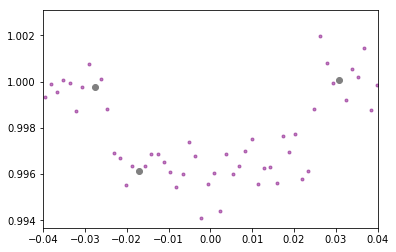

The radius ratio for planet h is:      0.0604
The impact parameter for planet h is:  0.8145


In [14]:
# Planet h: get radius ratio, impact parameters, and density
i = 6
plt.plot(df_h.TimefromMidTransit,df_h.Flux,'.',alpha=0.5,color=colors[i])
plt.xlim(-0.04,0.04)
plt.plot(-0.027606,0.999769,'o',color='Grey')
plt.plot(-0.017122,0.996121,'o',color='Grey')
plt.plot(0.030809,1.000054,'o',color='Grey')
plt.show()
#print(df_h[(df_h.TimefromMidTransit < 0.04) & (df_h.TimefromMidTransit > 0.01)])

# Index values for ingress/transit depth: 4271, 4277 ; and transit duration: 4327
h_transit_d = 0.999769 - 0.996121      # flux
h_ingress   = -0.017122 - (-0.027606)  # days
h_transit_t = 0.030809 - (-0.027606)   # days

h_k = get_radius_ratio(h_transit_d)
h_b = get_impact_param(h_k,h_transit_t,h_ingress)
#g_rho = get_density(g_P,g_transit_t,g_b)

print('The radius ratio for planet '+ planets[i] + ' is:      '+ str(round(h_k,4)))
print('The impact parameter for planet '+ planets[i] + ' is:  '+ str(round(h_b,4)))
#print('The density for planet '+ planets[i] + ' is:          ', round(g_rho,4))

$\textbf{Part b:}$


The three main advantages of observing the Trappist-1 system with Spitzer:
- No atmospheric noise
- Continuous observations (since the telescope is in space; i.e. no day/night limitations)
- High precision

$\textbf{Part d:}$

In [15]:
# Part d: Determine mass and radius of star
astar_rho = np.average([b_rho,c_rho,d_rho,e_rho,f_rho,g_rho])
print('Average density of star: ', round(astar_rho,5),r'g cm^-3')

astar_radius = get_stellar_radius(astar_F_bol,astar_T_eff,astar_dist) # cm
print(astar_radius/R_sun,'R_sun')

astar_mass   = (4*pi/3)*astar_rho*astar_radius**3. # g
print(astar_mass/M_sun,'M_sun')

Average density of star:  33.69634 g cm^-3
0.11600696479262561 R_sun
0.0373334505704 M_sun


The mass and radius of the Trappist-1 Star are ~0.04 M$_{\odot}$ and ~0.12 R$_{\odot}$, repectively.

$\textbf{Part e:}$

Given that we know the period of Planet g is ~12.4 days and we know that Planet h is the next planet out (given that transit depth is smaller and the transit duration is longer), I would estimate that Planet h has a period between 15 to 18 days.

$\textbf{Part f:}$

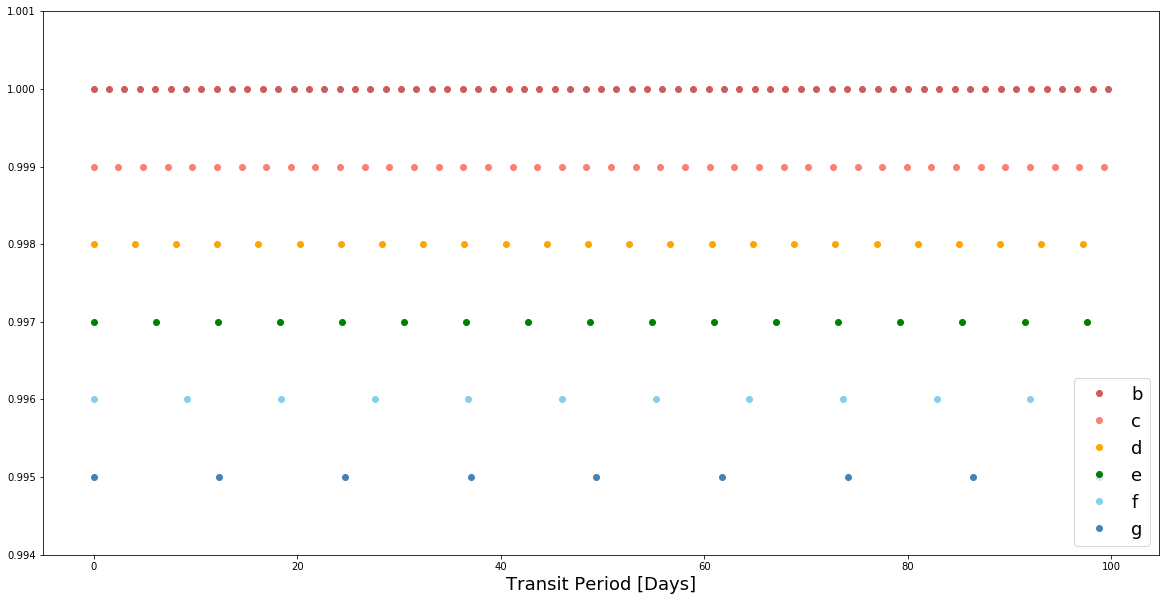

In [16]:
# Part f: Estimate a 100 day RV curve for all the planets
b_RV = np.arange(0,100,b_P)
c_RV = np.arange(0,100,c_P)
d_RV = np.arange(0,100,d_P)
e_RV = np.arange(0,100,e_P)
f_RV = np.arange(0,100,f_P)
g_RV = np.arange(0,100,g_P)
#print(g_RV)

off = 0.001
plt.figure(figsize=(20,10))
plt.plot(b_RV,np.ones(len(b_RV)),'o',color=colors[0],label=planets[0])
plt.plot(c_RV,np.ones(len(c_RV))-off,'o',color=colors[1],label=planets[1])
plt.plot(d_RV,np.ones(len(d_RV))-off*2,'o',color=colors[2],label=planets[2])
plt.plot(e_RV,np.ones(len(e_RV))-off*3,'o',color=colors[3],label=planets[3])
plt.plot(f_RV,np.ones(len(f_RV))-off*4,'o',color=colors[4],label=planets[4])
plt.plot(g_RV,np.ones(len(g_RV))-off*5,'o',color=colors[5],label=planets[5])
plt.xlabel('Transit Period [Days]',size=18)
plt.ylim(0.994,1.001)
plt.legend(prop={'size':18})
plt.show()

In [17]:
k_1,k_2,k_3 = -0.20945,0.0804,0.394

b_radius  = b_k*astar_radius/R_earth # R_earth
radius    = b_radius
b_M_water = scipy.optimize.fsolve(get_mass_watery,0.5)
b_M_rocky = scipy.optimize.fsolve(get_mass_rocky,0.5)
b_M_earth = scipy.optimize.fsolve(get_mass_earthy,0.5)

c_radius = c_k*astar_radius/R_earth
radius   = c_radius 
c_M_water = scipy.optimize.fsolve(get_mass_watery,0.5)
c_M_rocky = scipy.optimize.fsolve(get_mass_rocky,0.5)
c_M_earth = scipy.optimize.fsolve(get_mass_earthy,0.5)

d_radius = d_k*astar_radius/R_earth
radius   = d_radius
d_M_water = scipy.optimize.fsolve(get_mass_watery,0.5)
d_M_rocky = scipy.optimize.fsolve(get_mass_rocky,0.5)
d_M_earth = scipy.optimize.fsolve(get_mass_earthy,0.5)

e_radius = e_k*astar_radius/R_earth
radius   = e_radius
e_M_water = scipy.optimize.fsolve(get_mass_watery,0.5)
e_M_rocky = scipy.optimize.fsolve(get_mass_rocky,0.5)
e_M_earth = scipy.optimize.fsolve(get_mass_earthy,0.5)

f_radius = f_k*astar_radius/R_earth
radius   = f_radius
f_M_water = scipy.optimize.fsolve(get_mass_watery,0.5)
f_M_rocky = scipy.optimize.fsolve(get_mass_rocky,0.5)
f_M_earth = scipy.optimize.fsolve(get_mass_earthy,0.5)

g_radius = g_k*astar_radius/R_earth
radius   = g_radius
g_M_water = scipy.optimize.fsolve(get_mass_watery,0.5)
g_M_rocky = scipy.optimize.fsolve(get_mass_rocky,0.5)
g_M_earth = scipy.optimize.fsolve(get_mass_earthy,0.5)

h_radius = h_k*astar_radius/R_earth
radius   = h_radius
h_M_water = scipy.optimize.fsolve(get_mass_watery,0.5)
h_M_rocky = scipy.optimize.fsolve(get_mass_rocky,0.5)
h_M_earth = scipy.optimize.fsolve(get_mass_earthy,0.5)

In [18]:
print('       Radius, M_water, M_rocky, M_earth [R and M in earth units]')
print('Planet b:',round(b_radius,4),'',round(b_M_water[0],4),
      round(b_M_rocky[0],4),round(b_M_earth[0],4))
print('Planet c:',round(c_radius,4),round(c_M_water[0],4),
      round(c_M_rocky[0],4),round(c_M_earth[0],4))
print('Planet d:',round(d_radius,4),round(d_M_water[0],4),
      round(d_M_rocky[0],4),round(d_M_earth[0],4))
print('Planet e:',round(e_radius,4),round(e_M_water[0],4),
      round(e_M_rocky[0],4),round(e_M_earth[0],4))
print('Planet f:',round(f_radius,4),round(f_M_water[0],4),
      round(f_M_rocky[0],4),round(f_M_earth[0],4))
print('Planet g:',round(g_radius,4),round(g_M_water[0],4),
      round(g_M_rocky[0],4),'',round(g_M_earth[0],4))
print('Planet h:',round(h_radius,4),round(h_M_water[0],4),
      round(h_M_rocky[0],4),round(h_M_earth[0],4))

       Radius, M_water, M_rocky, M_earth [R and M in earth units]
Planet b: 1.141  1.1182 1.3491 1.7372
Planet c: 1.0547 0.8593 1.0361 1.327
Planet d: 0.7551 0.2888 0.3477 0.4382
Planet e: 0.9673 0.6452 0.7776 0.9909
Planet f: 1.0908 0.9614 1.1595 1.4883
Planet g: 1.0646 0.8864 1.069  1.3699
Planet h: 0.7646 0.3006 0.3619 0.4564


In [19]:
b_A_earth = get_RV_amp(b_P,b_M_earth,astar_mass) # cm/s
c_A_earth = get_RV_amp(c_P,c_M_earth,astar_mass)
d_A_earth = get_RV_amp(d_P,d_M_earth,astar_mass)
e_A_earth = get_RV_amp(e_P,e_M_earth,astar_mass)
f_A_earth = get_RV_amp(f_P,f_M_earth,astar_mass)
g_A_earth = get_RV_amp(g_P,g_M_earth,astar_mass)

b_A_rocky = get_RV_amp(b_P,b_M_rocky,astar_mass) # cm/s
c_A_rocky = get_RV_amp(c_P,c_M_rocky,astar_mass)
d_A_rocky = get_RV_amp(d_P,d_M_rocky,astar_mass)
e_A_rocky = get_RV_amp(e_P,e_M_rocky,astar_mass)
f_A_rocky = get_RV_amp(f_P,f_M_rocky,astar_mass)
g_A_rocky = get_RV_amp(g_P,g_M_rocky,astar_mass)

b_A_water = get_RV_amp(b_P,b_M_water,astar_mass) # cm/s
c_A_water = get_RV_amp(c_P,c_M_water,astar_mass)
d_A_water = get_RV_amp(d_P,d_M_water,astar_mass)
e_A_water = get_RV_amp(e_P,e_M_water,astar_mass)
f_A_water = get_RV_amp(f_P,f_M_water,astar_mass)
g_A_water = get_RV_amp(g_P,g_M_water,astar_mass)

print('Planet:                    b      c      d      e      f      g ')
print('Earth RV semi_amplitude:',round((b_A_earth[0]/100),4),round(c_A_earth[0]/100,4),'',
      round(d_A_earth[0]/100,4),round(e_A_earth[0]/100,4),
      round(f_A_earth[0]/100,4),round(g_A_earth[0]/100,4),'m/s') # m/s
print('Rocky RV semi_amplitude:',round(b_A_rocky[0]/100,4),round(c_A_rocky[0]/100,4),
      round(d_A_rocky[0]/100,4),round(e_A_rocky[0]/100,4),
      round(f_A_rocky[0]/100,4),round(g_A_rocky[0]/100,4),'m/s') # m/s
print('Water RV semi_amplitude:',round(b_A_water[0]/100,4),round(c_A_water[0]/100,4),
      round(d_A_water[0]/100,4),round(e_A_water[0]/100,4),
      round(f_A_water[0]/100,4),round(g_A_water[0]/100,4),'m/s') # m/s


Planet:                    b      c      d      e      f      g 
Earth RV semi_amplitude: 8.6649 5.656  1.5736 3.1043 4.0645 3.3919 m/s
Rocky RV semi_amplitude: 6.7293 4.4161 1.2485 2.4361 3.1665 2.6468 m/s
Water RV semi_amplitude: 5.5777 3.6624 1.0372 2.0214 2.6255 2.1949 m/s


When you examine a RV curve over about a 100 day range, it's noticable that a conjunction between the 6 inner planets (since we don't have a reliable Planet h period) occurs roughly every 37 days. Additionally, the RV calculations that assume an Earth-like composition have the greatest RV amplitudes. (Though they do all seem a bit small considering Earth has velocity of ~30 km/s; Maybe this has to do with the small mass of the Trappist-1 A star (M$_{Astar}$ ~ 0.03 M$_{\odot}$)? )

$\textbf{Part g:}$

In [20]:
# Part g: Estimate flux incident on planets
# F_inc = sigma*T_eff^4 * (R/a)^2
# T = 2R*P*(1-b^2)**0.5/(2\pi a)
b_R_a = b_transit_t*pi/(b_P*(1 - b_b**2)**0.5) 
c_R_a = c_transit_t*pi/(c_P*(1 - c_b**2)**0.5)
d_R_a = d_transit_t*pi/(d_P*(1 - d_b**2)**0.5)
e_R_a = e_transit_t*pi/(e_P*(1 - e_b**2)**0.5)
f_R_a = f_transit_t*pi/(f_P*(1 - f_b**2)**0.5)
g_R_a = g_transit_t*pi/(g_P*(1 - g_b**2)**0.5)

b_F_inc = (sigma*(astar_T_eff**4.)*(b_R_a)**2.)/F_inc_earth # E_incident flux
c_F_inc = (sigma*(astar_T_eff**4.)*(c_R_a)**2.)/F_inc_earth
d_F_inc = (sigma*(astar_T_eff**4.)*(d_R_a)**2.)/F_inc_earth
e_F_inc = (sigma*(astar_T_eff**4.)*(e_R_a)**2.)/F_inc_earth
f_F_inc = (sigma*(astar_T_eff**4.)*(f_R_a)**2.)/F_inc_earth
g_F_inc = (sigma*(astar_T_eff**4.)*(g_R_a)**2.)/F_inc_earth
print(b_F_inc,c_F_inc,d_F_inc,e_F_inc,f_F_inc,g_F_inc)

9.300196970511157 2.6639466617140144 3.906182624328031 1.0263339239657445 0.48121111329521365 0.5252370621111275


The incident flux on each of the planets is:
- F$_{inc,b}$ ~ 9.30 F$_{inc,\oplus}$ 
- F$_{inc,c}$ ~ 2.66 F$_{inc,\oplus}$
- F$_{inc,d}$ ~ 3.91 F$_{inc,\oplus}$
- F$_{inc,e}$ ~ 1.03 F$_{inc,\oplus}$
- F$_{inc,f}$ ~ 0.48 F$_{inc,\oplus}$
- F$_{inc,g}$ ~ 0.52 F$_{inc,\oplus}$

With the values in units of the incident flux at Earth, we'd probably want to visit Planet F first, though I would probably still want to bring sweaters just in case.